## This is notebook loads the TPU model and can then generates predictions for sequences and use this to evaluate its performance


### - The saved model weights for the TPU model can be found on Zenodo (Complex Media : https://zenodo.org/record/4436477/files/complex_media_fitness_function.h5?download=1 , Defined Media : https://zenodo.org/record/4436477/files/defined_media_fitness_function.h5?download=1) in addition to the directories referenced in the code (accessible from CodeOcean and the GCP vm)

#### Important Note for the Reviewers and Readers : 
- Our test datasets in the manuscript (for example the ones used in Fig. 1b,c, Extended Data Fig. 2, Supplementary Fig. 4, etc. ) are not simply held-out subsets of the training datasets. They are separate test datasets generated as part of completely independent experiments with lower-complexity (~1000 fold lower sequence diversity) libraries than the large-scale training data generation experiments resulting in expression measurements with a low measurement-error. The test data used here can be found in the `../../../data/test_data/` folder relative to this notebook's current directory.
- Since the training data and the test data are collected in different experiments, the units of expression are on different unrelated scales (the units are arbitrary units local to experiments and not absolute comparable units across experiments) because of the nature of GPRA/Sort-seq experiments.


### Imports

In [1]:

import sys
import rr_aux
from rr_aux import *
#%load_ext autoreload
#%autoreload 2
##Clear Memory 
tf.reset_default_graph()
tf.keras.backend.clear_session()
gc.collect()
##

rcParams['pdf.fonttype'] = 42


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3

### Load TPU model 
Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media GPU model here again for consistency. But, simply changing the model_conditions variable below should allow the user to the load the defined media model.

In [2]:
model_conditions='SC_Ura' # options : 'Glu'# 'Glu' refers to complex media, 'SC_Ura' refers to defined media

NUM_GPU = len(get_available_gpus())
if(NUM_GPU>0) :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

print(tf.__version__)
print(keras.__version__)
#tpu_grpc_url = TPUClusterResolver(tpu=['edv-tpu2'] , zone='us-central1-a').get_master()




### Load the Model in a separate graph here as there are two models in this figure.
fitness_function_graph = tf.Graph()
with fitness_function_graph.as_default():
    model, scaler,batch_size = load_model(model_conditions)

1.14.0
2.2.4-tf


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# Mean-vs-mean SSWM
Reproducing the SSWM validation experiment prediction result (Extended Data Fig. 2i) corresponding to Figure  2e-g using the TPU model's predictions 

Note : As we have shown in the manuscript, the complex and defined media have highly correlated expression levels and doing the same for defined media will lead to equiavalent prediction performance of the trained models. We use the loaded complex media TPU model here again for consistency.

##### First, we extract and save sequences corresponding to this experiment from a combined file containing multiple validation experiment results
In the full_df : 

- The seq110 columns denotes the sequences
- The meanEL denotes the measured expression (mean across each measured replicate)
- The edvPred contains the TPU model predictions


In the snp_df :
- The seq110 columns denotes the sequences
- The meanEL.mut denotes the measured expression of the sequence in the row (mean across each measured replicate)
- The edvPred.mut contains the TPU model predictions of the sequence in the row
- The meanEL.base denotes the expression of the starting sequence in the trajectory corresponding to the sequence in the row

##### Note : this file combines multiple different experiments, carefully extract individual experiments if using it on your own
Please feel free to write to us if you want to carry out analysis other than what we did in the paper if you have questions about our test (or training) datasets

##### Please be mindful of the difference in scales between experiments if you extract data from the file on your own

#### We have already carried out the extraction and saved the df file, so we directly load the saved df here

In [3]:
if 1 :  
    full_df = pd.read_csv('../../../data/test_data/combined_validation_experiments_data_with_annotations.txt' , sep='\t')
    snp_df = pd.read_csv('../../../data/test_data/singleBaseChanges_validation_experiments_data_with_annotations.txt' , sep='\t')
    
    ###Extract sequences corresponding to SSWM in the complex medium
    
    fig_df =full_df[(full_df.trajOpt=='SCUra') & (full_df.expt=='NBT_S288CdU_SCUra')]
    fig_df.loc[fig_df.trajDir=='dec' , 'trajDir'] = 'min'
    fig_df.loc[fig_df.trajDir=='inc','trajDir'] = 'max'


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Generate expression predictions using the TPU  model


In [4]:


if 1:
    sequences = list(fig_df.seq110.values) ### sequence
    expressions = list(fig_df['meanEL'].values) # Load expressions

    ### Predict Expression
    predicted_expressions = evaluate_model(sequences, model, scaler, batch_size , fitness_function_graph)
    fig_df['edvPred_gpu'] = predicted_expressions


min_df = fig_df[fig_df.trajDir == 'min'].groupby('ED').mean()
y_min = min_df.loc[:,['meanEL']].values.flatten()
x_min = min_df.loc[:,['edvPred_gpu']].values.flatten()

max_df = fig_df[fig_df.trajDir == 'max'].groupby('ED').mean()
y_max = max_df.loc[:,['meanEL']].values.flatten()
x_max = max_df.loc[:,['edvPred_gpu']].values.flatten()

df = pd.DataFrame(index = min_df.index, data = {'Predicted Expression' : x_min , 
                                          'Measured Expression' : y_min,
                                          'Direction' : 'Minimizing'} )

df = df.append(pd.DataFrame(index = max_df.index, data = {'Predicted Expression' : x_max , 
                                          'Measured Expression' : y_max,
                                          'Direction' : 'Maximizing'} ))

7168/7168 [==============================] - 6s 818us/sample


/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Compute and Print the Pearson's r between Measured and Predicted expression

In [5]:

pcc = scipy.stats.pearsonr(df['Measured Expression'],df['Predicted Expression'])[0]
print(f'The Pearson\'s r is', format(pcc, '0.3f'))


The Pearson's r is 0.999


### Plot the results 

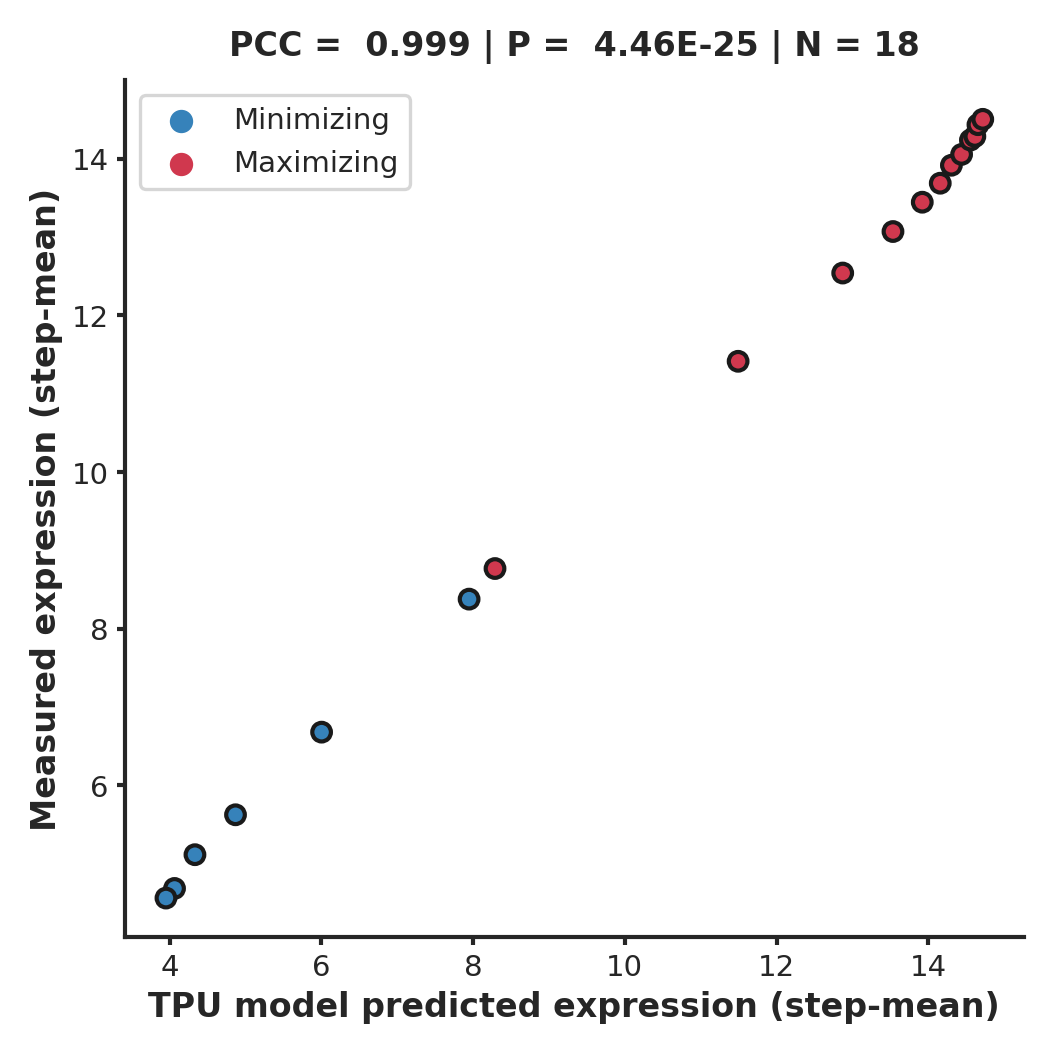

In [6]:
model_name = 'TPU model'

fig_file = model_name+" prediction_performance_sswm_mean_defined"

fig=plt.figure(figsize=(3.6,3.6) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)

custom_rb_color_palette = [sns.color_palette('Spectral_r' , n_colors = 10)[0]  ,
             sns.color_palette('Spectral_r' , n_colors = 10)[-1]]

x = list(df['Predicted Expression'])
y = list(df['Measured Expression'])
c = list(df['Direction'])

r = scipy.stats.pearsonr(x ,y )
sns.scatterplot(x=x ,y=y , hue=c, s= 20 , linewidth=1, rasterized = 1,  color= '#0868ac' , 
               alpha = 1, palette=custom_rb_color_palette , edgecolor= 'k')


ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression (step-mean)")
ax.set_ylabel("Measured expression (step-mean)")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

#ax.autoscale(enable=True, axis='x', tight=True)
#ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()